In [150]:
import torchaudio
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import signal
import multiprocessing
import math
import pandas as pd

from paths import *
from misc_progress_bar import draw_progress_bar

## Compare resample -> MFCC and MFCC-> resample|

In [151]:
import torchaudio
import torch
import scipy.signal as signal
import os
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt

from paths import *
from misc_tools import MyAudio

from python_speech_features import mfcc
from python_speech_features import delta
import scipy.io.wavfile as wav

In [152]:
        # self.transform = torchaudio.transforms.MFCC(sample_rate=sample_rate, 
        #                            n_mfcc=n_mfcc,
        #                            melkwargs={"n_fft": 512, 
        #                                       "win_length":400, 
        #                                       "hop_length":160, 
        #                                       "f_max": sample_rate/2, 
        #                                       "n_mels": 64})

        # feature = self.transform(waveform).squeeze(0).T

In [153]:
class MFCCTransform(nn.Module): 
    def __init__(self, sample_rate=16000, n_mfcc=13, normalizer=None): 
        super().__init__()
        self.normalizer = normalizer
        self.sample_rate = sample_rate
    
    def forward(self, waveform): 
        # extract mfcc

        feature = torchaudio.compliance.kaldi.mfcc(waveform, 
                                                   sample_frequency=self.sample_rate, 
                                                   dither=0, 
                                                   high_freq=8000)

        # add deltas
        d1 = torchaudio.functional.compute_deltas(feature)
        d2 = torchaudio.functional.compute_deltas(d1)
        feature = torch.cat([feature, d1, d2], dim=-1)

        # normalize
        if self.normalizer: 
            feature = self.normalizer(feature)

        return feature

class OldMFCCTransform(nn.Module): 
    def __init__(self, sample_rate=16000, normalizer=None): 
        super().__init__()
        self.normalizer = normalizer
        self.sample_rate = sample_rate
    
    def forward(self, waveform): 
        # extract mfcc

        waveform = waveform.squeeze(0).numpy()
        mfcc_feat = mfcc(waveform, self.sample_rate)
        delta_feat = delta(mfcc_feat, 2)
        delta_delta_feat = delta(delta_feat, 2)
        feature = np.concatenate((mfcc_feat, delta_feat, delta_delta_feat), axis=1)

        # normalize
        if self.normalizer: 
            feature = self.normalizer(feature)

        return feature



# class Resampler: 
#     @staticmethod
#     def resample_mfcc(mfcc, target_frame_num=25):
#         return torch.tensor(signal.resample(mfcc, target_frame_num, axis=0))
    
#     @staticmethod
#     def resample_wave(waveform, target_frame_num=4240):
#         return torch.tensor(signal.resample(waveform, target_frame_num, axis=1))
    
class Resampler(nn.Module): 
    def __init__(self, target_frame_num=25, axis=0): 
        super().__init__()
        self.target_frame_num = target_frame_num
        self.axis = axis
    
    def forward(self, mfcc): 
        return torch.tensor(signal.resample(mfcc, self.target_frame_num, axis=self.axis))


class Normalizer: 
    @staticmethod
    def norm_strip_mvn(mel_spec):
        eps = 1e-9
        mean = mel_spec.mean(1, keepdim=True)
        std = mel_spec.std(1, keepdim=True, unbiased=False)
        norm_spec = (mel_spec - mean) / (std + eps)
        return norm_spec
    
    @staticmethod
    def norm_time_mvn(mel_spec):
        eps = 1e-9
        mean = mel_spec.mean(0, keepdim=True)
        std = mel_spec.std(0, keepdim=True, unbiased=False)
        norm_spec = (mel_spec - mean) / (std + eps)
        return norm_spec

    @staticmethod
    def norm_minmax(mel_spec):
        min_val = mel_spec.min()
        max_val = mel_spec.max()
        norm_spec = (mel_spec - min_val) / (max_val - min_val)
        return norm_spec
    
    @staticmethod
    def norm_strip_minmax(mel_spec):
        min_val = mel_spec.min(1, keepdim=True)[0]
        max_val = mel_spec.max(1, keepdim=True)[0]
        norm_spec = (mel_spec - min_val) / (max_val - min_val)
        return norm_spec
    
    @staticmethod
    def norm_pcen(mel_spec):
        return mel_spec

In [161]:
transform = nn.Sequential(
    MFCCTransform(normalizer=Normalizer.norm_strip_mvn),
    Resampler(25, 0)
)

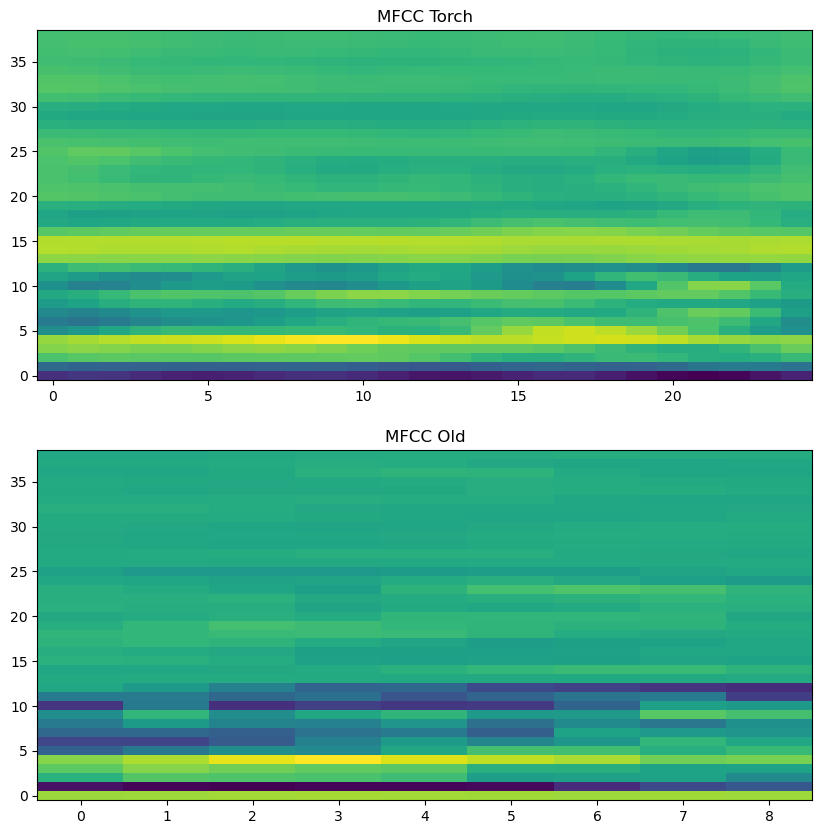

In [164]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].imshow(rmfcc.T, origin='lower', aspect='auto')
axs[0].set_title('MFCC Torch')
axs[1].imshow(sound_feat.T, origin='lower', aspect='auto')
axs[1].set_title('MFCC Old')
plt.show()

In [163]:
wave, sr = torchaudio.load(os.path.join(phone_seg_anno_rec_path, "s0101a_00000007.wav"))
rmfcc = transform(wave)

In [145]:
transformer = MFCCTransform() # normalizer=Normalizer.norm_strip_mvn

In [146]:
wave, sr = torchaudio.load(os.path.join(phone_seg_anno_rec_path, "s0101a_00000007.wav"))
omfcc = transformer(wave)
rmfcc = Resampler.resample_mfcc(omfcc, 25)

rwave = Resampler.resample_wave(wave, 4240)
rrmfcc = transformer(rwave)

In [147]:
(rate,sig) = wav.read(os.path.join(phone_seg_anno_rec_path, "s0101a_00000007.wav"))
# change to a list of samples with 13 features each
# delta is first order differential coefficient
mfcc_feat = mfcc(sig,rate)
delta_feat = delta(mfcc_feat, 2)
delta_delta_feat = delta(delta_feat, 2)
sound_feat = np.concatenate((mfcc_feat, delta_feat, delta_delta_feat), axis=1)

In [148]:
oldmfcc = old_mfcc(wave, sr)

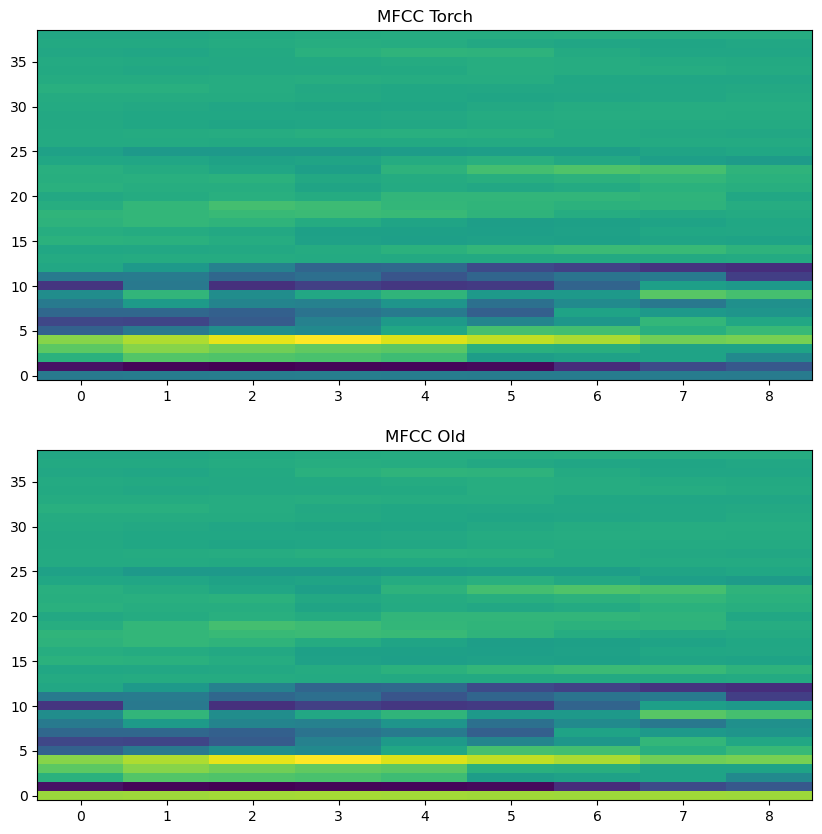

In [149]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].imshow(oldmfcc.T, origin='lower', aspect='auto')
axs[0].set_title('MFCC Torch')
axs[1].imshow(sound_feat.T, origin='lower', aspect='auto')
axs[1].set_title('MFCC Old')
plt.show()

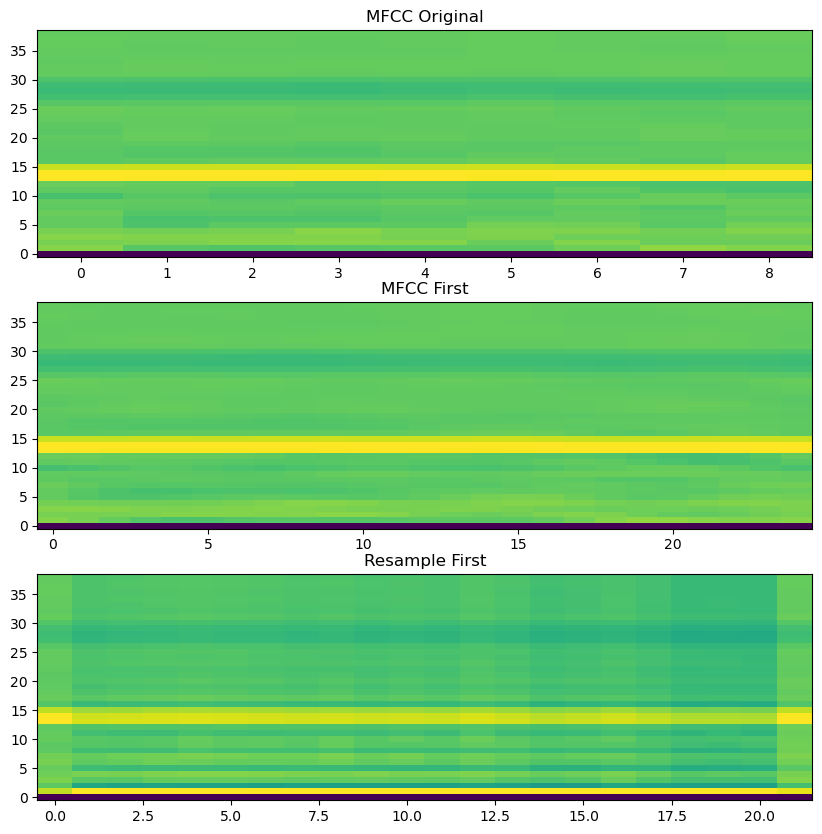

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(mfcc.T, origin='lower', aspect='auto')
axs[0].set_title('MFCC Original')
axs[1].imshow(rmfcc.T, origin='lower', aspect='auto')
axs[1].set_title('MFCC First')
axs[2].imshow(rrmfcc.T, origin='lower', aspect='auto')
axs[2].set_title('Resample First')
plt.show()

In [65]:
# define two MFCCs
mfcc1 = mfcc
mfcc2 = rmfcc
mfcc3 = rrmfcc

# compute the DTW distance between the two MFCCs
distance12, path12 = fastdtw(mfcc1, mfcc2, dist=euclidean)
distance23, path23 = fastdtw(mfcc2, mfcc3, dist=euclidean)
distance13, path13 = fastdtw(mfcc1, mfcc3, dist=euclidean)

print(distance12, distance23, distance13)


17.910973757300656 183.97695501446444 160.73665604883516


In [373]:
mfcc.shape

torch.Size([4, 39])

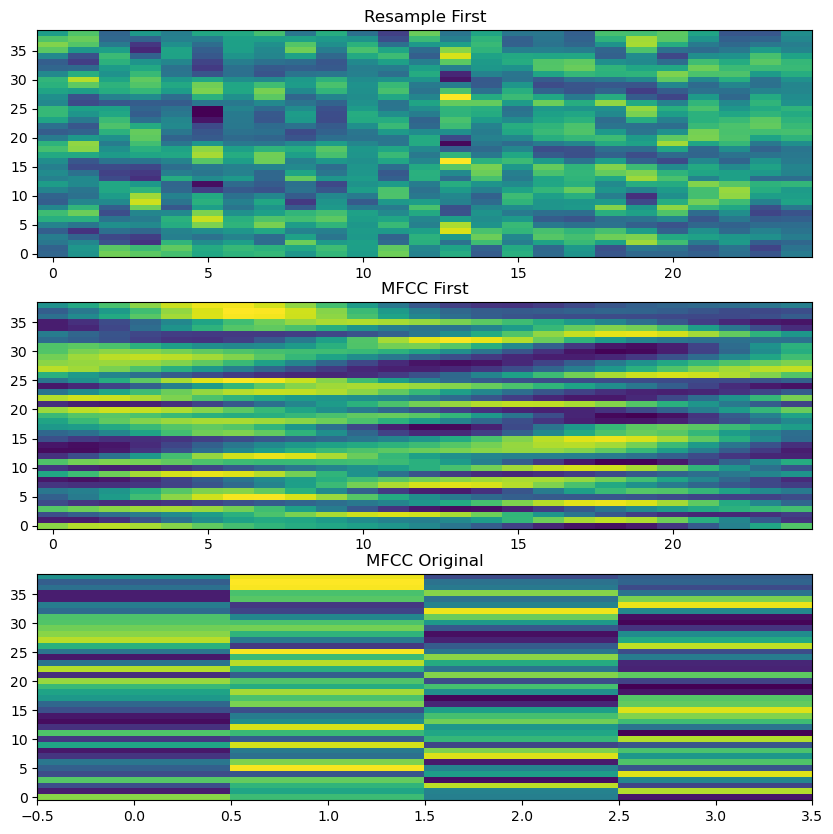

In [374]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(generated.T, origin='lower', aspect='auto')
axs[0].set_title('Resample First')
axs[1].imshow(resampled_mfcc.T, origin='lower', aspect='auto')
axs[1].set_title('MFCC First')
axs[2].imshow(mfcc.T, origin='lower', aspect='auto')
axs[2].set_title('MFCC Original')
plt.show()

In [375]:
import torch.nn.functional as F

mse = F.mse_loss(generated, resampled_mfcc)
print(f"MSE between original and resampled MFCC: {mse}")

MSE between original and resampled MFCC: 1.7655894756317139


In [376]:
# define two MFCCs
mfcc1 = generated
mfcc2 = resampled_mfcc
mfcc3 = mfcc

# compute the DTW distance between the two MFCCs
distance12, path12 = fastdtw(mfcc1, mfcc2, dist=euclidean)
distance23, path23 = fastdtw(mfcc2, mfcc3, dist=euclidean)
distance13, path13 = fastdtw(mfcc1, mfcc3, dist=euclidean)

print(distance12, distance23, distance13)


203.0177719790435 72.95747132461258 196.96640347495085


In [20]:
path23

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 3),
 (14, 3),
 (15, 3),
 (16, 3),
 (17, 3),
 (18, 4),
 (19, 4),
 (20, 4),
 (21, 4),
 (22, 4),
 (23, 4),
 (24, 4)]

In [21]:
import librosa

In [369]:
wave, sr = torchaudio.load(os.path.join(phone_seg_anno_rec_path, "s0101a_00000265.wav"))

In [370]:
MyAudio.play_audio_np(np.array(wave), sr)

In [351]:
new_sr = sr*(4240/wave.size(1))

In [352]:
mfcclib = librosa.feature.mfcc(y=np.array(wave)[0], 
                                sr=16000, n_fft=400, n_mfcc=13, 
                                win_length=400, hop_length=160)

In [353]:
resampled_wave = signal.resample(wave, 4240, axis=1)

In [354]:
mfcclibres = librosa.feature.mfcc(y=np.array(resampled_wave)[0], 
                                  sr=16000, n_fft=400, n_mfcc=13, 
                                  win_length=400, hop_length=160)

In [355]:
mfcclibrespost = signal.resample(mfcclib, 25, axis=1)

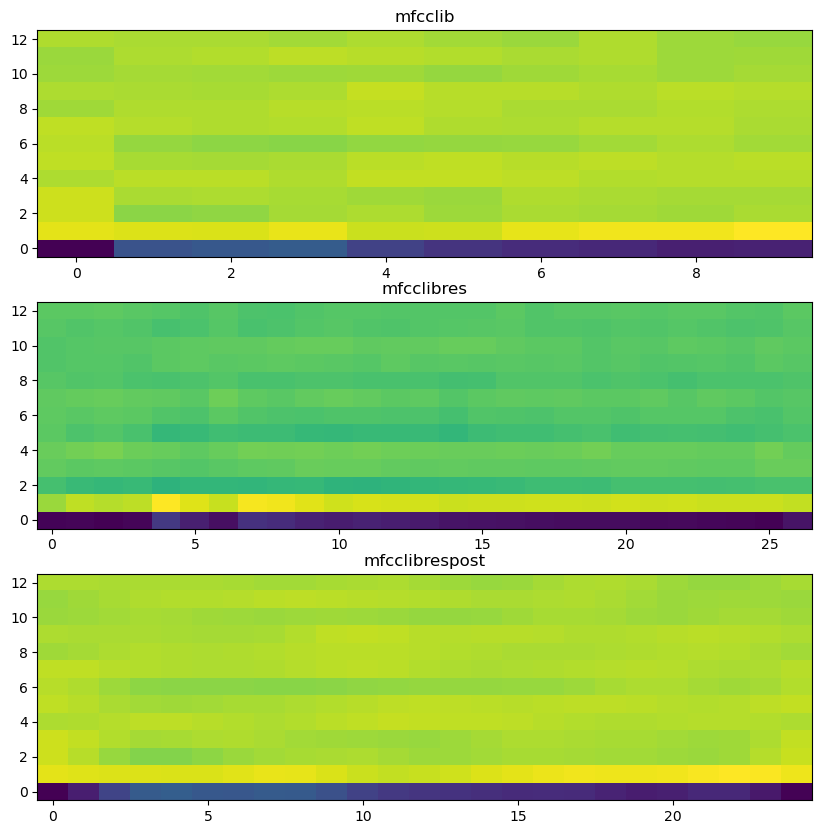

In [356]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(mfcclib, origin='lower', aspect='auto')
axs[0].set_title('mfcclib')
axs[1].imshow(mfcclibres, origin='lower', aspect='auto')
axs[1].set_title('mfcclibres')
axs[2].imshow(mfcclibrespost, origin='lower', aspect='auto')
axs[2].set_title('mfcclibrespost')
plt.show()

In [357]:
# define two MFCCs
mfcc1 = mfcclib.T
mfcc2 = mfcclibres.T
mfcc3 = mfcclibrespost.T

# compute the DTW distance between the two MFCCs
distance12, path12 = fastdtw(mfcc1, mfcc2, dist=euclidean)
distance23, path23 = fastdtw(mfcc2, mfcc3, dist=euclidean)
distance13, path13 = fastdtw(mfcc1, mfcc3, dist=euclidean)

print(distance12, distance23, distance13)


5968.331193321344 6675.6031425774145 601.6500644270097


In [358]:
mfcclibau = librosa.feature.inverse.mfcc_to_audio(np.array(mfcclib), 
                                sr=16000, n_fft=400, 
                                win_length=400, hop_length=160)

In [359]:
mfcclibresau = librosa.feature.inverse.mfcc_to_audio(np.array(mfcclibres), 
                                sr=16000, n_fft=400, 
                                win_length=400, hop_length=160)

In [360]:
mfcclibrespostau = librosa.feature.inverse.mfcc_to_audio(np.array(mfcclibrespost), 
                                sr=16000, n_fft=400, 
                                win_length=400, hop_length=160)

In [361]:
postsr = sr*(25/mfcclib.shape[1])

In [362]:
MyAudio.play_audio_np(np.array(wave), sr)

In [363]:
MyAudio.play_audio_np(np.expand_dims(mfcclibau, axis=0), sr)

In [364]:
MyAudio.play_audio_np(resampled_wave, new_sr)

In [365]:
MyAudio.play_audio_np(np.expand_dims(mfcclibresau, axis=0), new_sr)

In [366]:
MyAudio.play_audio_np(np.expand_dims(mfcclibrespostau, axis=0), postsr)

In [367]:
from scipy.io import wavfile

In [368]:
wavfile.write("cons_original.wav", sr, np.array(wave.squeeze(0)))
wavfile.write("cons_resampled.wav", int(new_sr), np.array(resampled_wave.squeeze(0)))
wavfile.write("cons_MFCC_recon.wav", sr, mfcclibau)
wavfile.write("cons_RFMFCC_recon.wav", int(new_sr), mfcclibresau)
wavfile.write("cons_MFMFCC_recon.wav", int(postsr), mfcclibrespostau)

In [323]:
torchaudio.save("test_original.wav", wave, sr)
torchaudio.save("test_resampled.wav", wave, int(new_sr))
torchaudio.save("test_MFCC_recon.wav", torch.tensor(mfcclibau).unsqueeze(0), sr)
torchaudio.save("test_RFMFCC_recon.wav", torch.tensor(mfcclibresau).unsqueeze(0), new_sr)
torchaudio.save("test_MFMFCC_recon.wav", torch.tensor(mfcclibrespostau).unsqueeze(0), postsr)

TypeError: add_audio_stream(): incompatible function arguments. The following argument types are supported:
    1. (self: torchaudio.lib._torchaudio_ffmpeg4.StreamWriter, arg0: int, arg1: int, arg2: str, arg3: Optional[str], arg4: Optional[Dict[str, str]], arg5: Optional[str], arg6: Optional[int], arg7: Optional[int], arg8: Optional[torchaudio.lib._torchaudio_ffmpeg4.CodecConfig], arg9: Optional[str]) -> None

Invoked with: <torchaudio.lib._torchaudio_ffmpeg4.StreamWriter object at 0x7f13c90c1970>, 43852.617970265026, 1, 'flt', 'pcm_s16le', None, None, None, None, None, None

In [165]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, stride=1):
        super(ResidualBlock, self).__init__()

        # Linear layer with batch normalization and ReLU activation
        self.linear1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU(inplace=True)

        # Linear layer with batch normalization
        self.linear2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)

        # Shortcut connection if input and output dimensions are different
        self.shortcut = nn.Sequential()
        if stride != 1 or in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features, bias=False),
                nn.BatchNorm1d(out_features)
            )

    def forward(self, x):
        # Main path
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)

        # Shortcut connection
        shortcut = self.shortcut(x)

        # Residual connection
        out += shortcut
        out = self.relu(out)

        return out

# Example usage
input_size = 10
output_size = 5
residual_block = ResidualBlock(input_size, output_size)

# Example input
x = torch.randn(1, input_size)

# Forward pass
output = residual_block(x)
print(output)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 5])

In [3]:
import torch
import torch.nn as nn

# Define the input and target tensors
input_tensor = torch.rand((3, 5, 6), dtype=torch.float32)
target_tensor = torch.rand((3, 5, 6), dtype=torch.float32)

# Define the criterion with different reduction methods
criterion_mean = nn.MSELoss(reduction='mean')
criterion_sum = nn.MSELoss(reduction='sum')
criterion_none = nn.MSELoss(reduction='none')

# Calculate the loss using different reduction methods
loss_mean = criterion_mean(input_tensor, target_tensor)
loss_sum = criterion_sum(input_tensor, target_tensor)
loss_none = criterion_none(input_tensor, target_tensor)

# Print the calculated losses
print("Loss with 'mean' reduction:", loss_mean.shape)
print("Loss with 'sum' reduction:", loss_sum.shape)
print("Loss with 'none' reduction:", loss_none.shape)


Loss with 'mean' reduction: torch.Size([])
Loss with 'sum' reduction: torch.Size([])
Loss with 'none' reduction: torch.Size([3, 5, 6])


In [7]:
loss_none.view(size=(3, -1)).mean(dim=-1)

tensor([0.1931, 0.2526, 0.1741])

In [2]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import os
import math
from multiprocessing import Pool, cpu_count
import sys

from paths import *
from ssd_paths import *
from mio import *
from sampler import *
from my_utils import *
from sound_proc import *

In [6]:
filtered_df = filter_tokens_and_get_df(os.path.join(as_phones_extract_path, "log.csv"), keepSIL=False)

In [11]:
def open_and_cut(wave_path, wave_name, filtered_df, params, no_real_cut=False):
    # filtered_df = filter_tokens_and_get_df(annos_path, keepSIL=False)
    filtered_df = filtered_df[filtered_df["rec"] == wave_name]
    flat_starts, flat_ends, c_duration = filtered_df["start_time"].to_numpy(), filtered_df["end_time"].to_numpy(), filtered_df["duration"].to_numpy()

    if not no_real_cut: 
        sp = Sound_Proc()
    
        rec, sample_rate = torchaudio.load(wave_path)

        cut_recs = sp.cut_rec(rec, flat_starts, flat_ends)

        # NOTE: This is added because a very small proportion of the data are strangely having zero n_frames (which I don't know yet why)
        # to filter them out, I added this n_frames
        cut_n_frames = [cut_rec.shape[1] for cut_rec in cut_recs]
        cut_n_frames = np.array(cut_n_frames)
    else: 
        pass
        # ref_anno_df = pd.read_csv(os.path.join(word_seg_anno_log_ref_path, os.path.basename(annos_path)))
        # assert ref_anno_df.shape[0] == filtered_df.shape[0]
        # cut_n_frames = ref_anno_df["n_frames"].to_numpy()
        # cut_recs = []
    
    tokens = filtered_df["token"].to_numpy()
    
    cst, cet = flat_starts, flat_ends
    
    
    # Framify
    # Create a dictionary with the three lists as values and the column names as keys
    data = {'rec': wave_name, "idx": list(map("{:08d}".format, range(len(c_duration)))), 'start_time': cst, 'end_time': cet, 'token': tokens, 'duration': c_duration, 'n_frames':cut_n_frames}
    # Create a Pandas DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return cut_recs, df

In [12]:
wavename = "SSB00050003.wav"
rec_raw, ext = os.path.splitext(wavename)

In [13]:
open_and_cut(os.path.join(as_wav_path, wavename), rec_raw, filtered_df, None)

([tensor([[ 0.0027,  0.0027,  0.0027,  ...,  0.0060, -0.0048, -0.0091]]),
  tensor([[-0.0138, -0.0210, -0.0298,  ...,  0.0095,  0.0164,  0.0183]]),
  tensor([[0.0284, 0.0411, 0.0483,  ..., 0.0981, 0.0868, 0.0770]]),
  tensor([[ 0.0638,  0.0524,  0.0463,  ...,  0.0004, -0.0062, -0.0140]]),
  tensor([[-0.0221, -0.0318, -0.0423,  ...,  0.0255,  0.0186,  0.0130]]),
  tensor([[ 0.0087,  0.0056,  0.0027,  ..., -0.0373, -0.0350, -0.0294]]),
  tensor([[-0.0224, -0.0121, -0.0027,  ...,  0.0180,  0.0220,  0.0252]]),
  tensor([[ 0.0280,  0.0263,  0.0233,  ..., -0.0920, -0.0887, -0.0857]]),
  tensor([[-0.0747, -0.0594, -0.0455,  ...,  0.0916,  0.0977,  0.0937]]),
  tensor([[ 8.6639e-02,  7.5226e-02,  5.9814e-02,  ..., -3.0518e-05,
           -1.2512e-03, -5.7983e-04]]),
  tensor([[ 0.0013,  0.0015,  0.0014,  ...,  0.0006,  0.0004, -0.0003]])],
             rec       idx  start_time  end_time token  duration  n_frames
 0   SSB00050003  00000000        0.48      0.68     q      0.20      3200
 1   S

In [30]:
from misc_tools import MyAudio
import torchaudio

In [31]:
df = pd.read_csv(os.path.join(as_phone_seg_anno_log_path, "log.csv"))

In [62]:
random_row = df.sample(n=1)
filename = f"{random_row['rec'].item()}_{random_row['idx'].item():08d}.wav"
token = random_row['token'].item()
print(token)
waveform, sr = torchaudio.load(os.path.join(as_phone_seg_anno_path, filename))
MyAudio.play_audio_torch(waveform, sr)

ch


## OK cutting. 

In [2]:
import os
import pandas as pd
from ssd_paths import *

In [3]:
len(os.listdir(as_phone_seg_random_MF_path))

41432

In [4]:
guide_log = pd.read_csv(os.path.join(as_use_path, 'phone_random_train.csv'))

In [7]:
rec_list = guide_log["rec"].str[:7].unique().tolist()

In [8]:
rec_list

['SSB0009',
 'SSB0038',
 'SSB0073',
 'SSB0080',
 'SSB0197',
 'SSB0200',
 'SSB0267',
 'SSB0287',
 'SSB0307',
 'SSB0309',
 'SSB0316',
 'SSB0339',
 'SSB0341',
 'SSB0342',
 'SSB0354',
 'SSB0366',
 'SSB0379',
 'SSB0380',
 'SSB0427',
 'SSB0435',
 'SSB0470',
 'SSB0482',
 'SSB0502',
 'SSB0534',
 'SSB0539',
 'SSB0565',
 'SSB0570',
 'SSB0578',
 'SSB0588',
 'SSB0590',
 'SSB0601',
 'SSB0603',
 'SSB0606',
 'SSB0607',
 'SSB0609',
 'SSB0614',
 'SSB0623',
 'SSB0666',
 'SSB0668',
 'SSB0671',
 'SSB0710',
 'SSB0723',
 'SSB0737',
 'SSB0746',
 'SSB0748',
 'SSB0751',
 'SSB0760',
 'SSB0762',
 'SSB0778',
 'SSB0780',
 'SSB0784',
 'SSB0786',
 'SSB0794',
 'SSB0935',
 'SSB0966',
 'SSB0987',
 'SSB1020',
 'SSB1056',
 'SSB1072',
 'SSB1096',
 'SSB1100',
 'SSB1115',
 'SSB1125',
 'SSB1131',
 'SSB1563',
 'SSB1567',
 'SSB1593',
 'SSB1624',
 'SSB1625',
 'SSB1828']

In [13]:
guide_log[guide_log['n_frames'] <= 400]

,rec,idx,start_time,end_time,token,duration,n_frames,global_idx


In [14]:
guide_log[guide_log['duration'] > 2.0]

,rec,idx,start_time,end_time,token,duration,n_frames,global_idx


In [1]:
import torch

In [2]:
torch.cuda.is_available()

True